In [122]:
import torch
import numpy as np
import os
import random
import pandas as pd
from astropy.io import fits
from case_studies.galaxy_clustering.utils import diagnostics
import matplotlib.pyplot as plt

In [107]:
DES_DIR = "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles"
DES_BANDS = ("g", "r", "i", "z")
DES_SUBDIRS = [d for d in os.listdir(DES_DIR) if d.startswith("DES")]
tiles_per_img = 64

In [108]:
def convert_to_global_idx(tile_idx, gpu_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    dir_idx = int(num_gpus * (tile_idx // (tiles_per_img / batch_size)) + gpu_idx)
    subimage_idx = [(batch_size * tile_idx + i) % tiles_per_img for i in range(batch_size)]
    return dir_idx, subimage_idx

def convert_to_tile_idx(dir_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    gpu_idx = dir_idx % num_gpus
    tile_starting_idx = (tiles_per_img / batch_size) * (dir_idx // num_gpus)
    return int(tile_starting_idx), int(gpu_idx)

In [109]:
tile_idx = 0
gpu_idx = 0

dir_idx, subimage_idx = convert_to_global_idx(tile_idx, gpu_idx)
print(f"Directory: {DES_SUBDIRS[dir_idx]}")
print(f"Subimage: {subimage_idx}")

Directory: DES0053-2041
Subimage: [0, 1]


In [110]:
memberships = torch.empty((0,10,10))
output_dir = "/data/scratch/des/dr2_detection_output/run_0"
dir_idx = 10167
tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
for tile in range(tile_starting_idx, tile_starting_idx + 32):
    file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
    memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)

expanded_memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
expanded_memberships = torch.repeat_interleave(expanded_memberships, repeats=128, dim=2)
expanded_memberships.shape

torch.Size([64, 1280, 1280])

In [34]:
# gpu 0 : 0, 2, 4, 6, 8, ...
# gpu 1 : 1, 3, 5, 7, 9, ...

# tile_0 : 0, 1             -- image 0
# tile_1 : 2, 3             -- image 0
# tile_2 : 4, 5             -- image 0
# ...
# tile_31 : 62, 63          -- image 0
# tile_32 : 64, 65          -- image 1 (image 2 overall)

# tile_t_gpu_g --> dir_id = 2 * (t // 32) + g
#              --> sub_id = (2*t % 64), (2*t + 1) % 64

500

In [111]:
def count_num_clusters(dir_idx):
    memberships = torch.empty((0,10,10))
    tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
    for tile in range(tile_starting_idx, tile_starting_idx + 32):
        file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
        memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=2)
    return torch.any(memberships.view(memberships.shape[0], -1), dim=1).sum()

In [114]:
num_clusters = pd.read_pickle("/data/scratch/des/num_clusters.pickle")
num_clusters

{'DES0053-2041': tensor(0),
 'DES0330-1250': tensor(2),
 'DES2225+0001': tensor(1),
 'DES0102-6205': tensor(0),
 'DES0409-2458': tensor(0),
 'DES0113-0624': tensor(1),
 'DES0535-5248': tensor(2),
 'DES0547-4957': tensor(1),
 'DES0216-1207': tensor(0),
 'DES2242-4457': tensor(1),
 'DES0051-3957': tensor(0),
 'DES0226-4540': tensor(2),
 'DES0011+0252': tensor(2),
 'DES0311-3332': tensor(0),
 'DES0218-0750': tensor(0),
 'DES0325-2706': tensor(2),
 'DES2351+0043': tensor(1),
 'DES0324-5123': tensor(1),
 'DES0524-3540': tensor(0),
 'DES0246-1832': tensor(0),
 'DES2125-6331': tensor(0),
 'DES0353-2458': tensor(0),
 'DES2239-4748': tensor(17),
 'DES0604-4706': tensor(0),
 'DES0534-3957': tensor(0),
 'DES0055-2958': tensor(0),
 'DES2100-5748': tensor(2),
 'DES0209-3957': tensor(2),
 'DES0437-5540': tensor(2),
 'DES0100-2458': tensor(2),
 'DES0313-2832': tensor(1),
 'DES0238-1958': tensor(0),
 'DES0218-4249': tensor(0),
 'DES2030-5040': tensor(1),
 'DES0413-3914': tensor(0),
 'DES0250-4748': te

In [116]:
for k, v in num_clusters.items():
    if v == 1:
        print(k)

DES2225+0001
DES0113-0624
DES0547-4957
DES2242-4457
DES2351+0043
DES0324-5123
DES0313-2832
DES2030-5040
DES0541-4457
DES2357+0209
DES2109-6039
DES0344-3914
DES0526-3249
DES0217-0915
DES0116-4249
DES0138-2915
DES0526-5040
DES0322-1415
DES0408-4540
DES2142+0043
DES2358-4414
DES0554-3206
DES0332-5831
DES2241-5040
DES0301-3623
DES0049-2124
DES0347-3914
DES0108-5331
DES0423-6205
DES2321-3957
DES0037-2749
DES2241-4540
DES0102+0209
DES0243-5123
DES2316-4123
DES0335-1458
DES2339-0041
DES2333-5957
DES0020-5831
DES0224-2749
DES0126-4831
DES2238-4457
DES0140+0335
DES0223-0333
DES2051-6039
DES0137-4748
DES0306-2249
DES0315-2623
DES0134+0001
DES0152-4123
DES0152-1958
DES0106-5248
DES0240-2749
DES0243-0915
DES0207-1624
DES0543-3706
DES0117-6122
DES0100-3332
DES0312-4706
DES0319-4540
DES0611-4831
DES0257-0707
DES0412-2458
DES0333-4040
DES0259-3457
DES0222-0624
DES0408-3957
DES0559-5831
DES0142-0124
DES0150-4748
DES0321-5622
DES2205-5748
DES0224-2706
DES2252-4748
DES0055-2623
DES0613-3623
DES0414-5040

In [117]:
dir = "DES0547-4957"
dir_idx = DES_SUBDIRS.index(dir)

In [119]:
memberships = torch.empty((0,10,10))
tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
for tile in range(tile_starting_idx, tile_starting_idx + 32):
    file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
    memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)
memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
memberships = torch.repeat_interleave(memberships, repeats=128, dim=2)
memberships.shape

torch.Size([64, 1280, 1280])

In [120]:
image_g = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/DES0547-4957_r4939p01_g_nobkg.fits.fz"))
image_r = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/DES0547-4957_r4939p01_r_nobkg.fits.fz"))
image_i = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/DES0547-4957_r4939p01_i_nobkg.fits.fz"))
image_z = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/DES0547-4957_r4939p01_z_nobkg.fits.fz"))

In [121]:
full_image = torch.stack([image_g, image_r, image_i, image_z], axis=0)
image = full_image.unfold(dimension=1, size=1280, step=1235).unfold(
                dimension=2, size=1280, step=1235
            )
            # Finally obtain (4, 64, 1280, 1280)
image = image.reshape(4, -1, 1280, 1280)
image.shape

torch.Size([4, 64, 1280, 1280])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


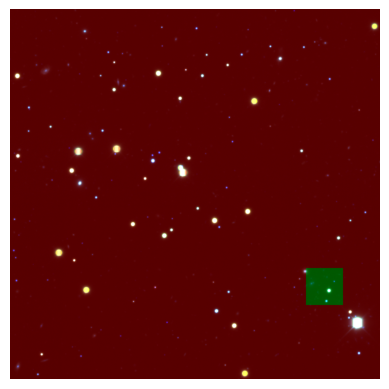

In [127]:
test_out = memberships[14,:,:]
test_img = image[:3,14,:,:]
overlay = diagnostics.create_overlay(test_out, tile_size=1)
blended_image = diagnostics.blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()